### 파이썬 미니 프로젝트 11조

In [44]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

In [46]:
[ (font.name, font.fname) for font in fm.fontManager.ttflist if 'Mal' in font.name ]

font_path = 'C:\\Windows\\Fonts\\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()

matplotlib.rc('font', family=font_prop)

#### 1. 데이터 수집

In [47]:
# url과 파라미터 설정 + 결과 확인
url = 'http://apis.data.go.kr/1352000/ODMS_STAT_09/callStat09Api'
key = os.getenv("SERVICE_KEY")
params ={'serviceKey' : f'{key}', 'apiType' : 'JSON'}

response = requests.get(url, params=params)
print(response.content)

# 서버의 응답 상태 출력
print(response.status_code) 

b'{"pageNo":"1","resultCode":"00","totalCount":68,"items":[{"dsStdrSrvrt":"13.6","allSvr":"14","allStdrSrvrt":"9.3","year":"2016","dsSvr":"11","othdsStdrSrvrt":"6","dsSrvrt":"13.9","othdsSvr":"3","dvsd":"\xec\x84\xb8\xec\xa2\x85","allSrvrt":"11.9","othdsSrvrt":"7.9"},{"dsStdrSrvrt":"8.6","allSvr":"71","allStdrSrvrt":"5.5","year":"2016","dsSvr":"59","othdsStdrSrvrt":"2.8","dsSrvrt":"5.5","othdsSvr":"12","dvsd":"\xec\xa0\x84\xeb\x82\xa8","allSrvrt":"4.7","othdsSrvrt":"2.8"},{"dsStdrSrvrt":"10.8","allSvr":"37","allStdrSrvrt":"7.8","year":"2017","dsSvr":"30","othdsStdrSrvrt":"5.1","dsSrvrt":"6","othdsSvr":"7","dvsd":"\xec\xa0\x9c\xec\xa3\xbc","allSrvrt":"5.8","othdsSrvrt":"5.5"},{"dsStdrSrvrt":"11.1","allSvr":"92","allStdrSrvrt":"8.1","year":"2016","dsSvr":"86","othdsStdrSrvrt":"2.3","dsSrvrt":"8.5","othdsSvr":"6","dvsd":"\xeb\x8c\x80\xea\xb5\xac","allSrvrt":"7","othdsSrvrt":"2.1"},{"dsStdrSrvrt":"8.8","allSvr":"69","allStdrSrvrt":"6.2","year":"2016","dsSvr":"59","othdsStdrSrvrt":"2.4","ds

In [48]:
def api_df(num):
    
    url = f'http://apis.data.go.kr/1352000/ODMS_STAT_{num}/callStat{num}Api'
    key = os.getenv("SERVICE_KEY")
    params ={'serviceKey' : f'{key}', 
             'apiType' : 'JSON'}

    response = requests.get(url, params=params)
    # 응답 상태가 정상인 경우 (200)에 데이터프레임 반환
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['items'])
        return df
    else:
        print(f"오류 발생: {response.status_code}")

In [49]:
# 급성심장정지 발생률
heart_occur_eng = api_df('08')

# 급성심장정지 생존율
heart_live_eng = api_df('09')

# 급성심장정지 뇌기능 회복률
heart_heal_eng = api_df('10')

In [50]:
# 전국 병원 데이터 csv 파일 불러오기
hospital_df_eng = pd.read_csv("보건복지부_병원 및 의원 수_의료기관 종류별_시도별_20221231.csv", encoding='cp949')

#### 2. 데이터 전처리

In [51]:
# 급성심장정지 데이터프레임의 연도, 지역 컬럼을 앞으로 불러오기
# 알아보기 힘든 컬럼 이름 수정

front_cols = ['year', 'dvsd']
heart_occur_eng = heart_occur_eng[front_cols + [col for col in heart_occur_eng.columns if col not in front_cols]]

heart_occur = heart_occur_eng.rename(columns={
    'year': '연도',
    'dvsd': '시도',
    'allStdrOcrt': '전체 표준화 발생률',
    'othdsOcrt': '질병외 발생률',
    'dsStdrOcrt': '질병 표준화 발생률',
    'allOcrt': '전체 발생률',
    'allOccr': '전체 발생',
    'dsOcrt': '질병 발생률',
    'dsOccr': '질병 발생',
    'othdsStdrOcrt': '질병외 표준화 발생률',
    'othdsOccr': '질병외 발생'
})

ordered_occur = [
    '연도', '시도',
    '전체 발생', '전체 발생률', '전체 표준화 발생률',
    '질병 발생', '질병 발생률', '질병 표준화 발생률',
    '질병외 발생', '질병외 발생률', '질병외 표준화 발생률'
]

# 데이터타입 object에서 float나 int형식으로 변경
heart_occur = heart_occur[ordered_occur]
heart_occur = heart_occur.sort_values(by='연도').reset_index(drop=True)
heart_occur[heart_occur.columns.difference(['시도'])] = heart_occur[heart_occur.columns.difference(['시도'])].apply(pd.to_numeric, errors='coerce')

heart_occur.head()

,연도,시도,전체 발생,전체 발생률,전체 표준화 발생률,질병 발생,질병 발생률,질병 표준화 발생률,질병외 발생,질병외 발생률,질병외 표준화 발생률
0,2016,전남,1575,83.2,46.9,1077,56.9,27.8,422,22.3,16.9
1,2016,대전,707,47.0,36.5,521,34.6,26.2,175,11.6,9.9
2,2016,경북,2241,83.5,49.3,1542,57.5,30.7,577,21.5,16.0
3,2016,세종,118,52.2,45.1,79,35.0,29.1,38,16.8,15.6
4,2016,광주,640,43.8,35.1,484,33.1,25.4,142,9.7,8.9


In [52]:
heart_live_eng = heart_live_eng[front_cols + [col for col in heart_live_eng.columns if col not in front_cols]]

heart_live = heart_live_eng.rename(columns={
    'year': '연도',
    'dvsd': '시도',
    'dsStdrSrvrt': '질병 표준화 생존률',
    'allSvr': '전체 생존',
    'allStdrSrvrt': '전체 표준화 생존률',
    'dsSvr': '질병 생존',
    'othdsStdrSrvrt': '질병외 표준화 생존률',
    'dsSrvrt': '질병 생존율',
    'othdsSvr': '질병외 생존',
    'allSrvrt': '전체 생존율',
    'othdsSrvrt': '질병외 생존율'
})

ordered_live = [
    '연도', '시도',
    '전체 생존', '전체 생존율', '전체 표준화 생존률',
    '질병 생존', '질병 생존율', '질병 표준화 생존률',
    '질병외 생존', '질병외 생존율', '질병외 표준화 생존률'
]

# 데이터타입 object에서 float나 int형식으로 변경
heart_live = heart_live[ordered_live]
heart_live = heart_live.sort_values(by='연도').reset_index(drop=True)
heart_live[heart_live.columns.difference(['시도'])] = heart_live[heart_live.columns.difference(['시도'])].apply(pd.to_numeric, errors='coerce')

heart_live.head()

,연도,시도,전체 생존,전체 생존율,전체 표준화 생존률,질병 생존,질병 생존율,질병 표준화 생존률,질병외 생존,질병외 생존율,질병외 표준화 생존률
0,2016,세종,14,11.9,9.3,11,13.9,13.6,3.0,7.9,6.0
1,2016,부산,174,9.1,10.1,145,9.8,13.2,26.0,6.3,5.8
2,2016,대전,59,8.4,9.3,52,10.0,11.7,7.0,4.0,4.0
3,2016,경북,92,4.3,4.8,84,5.4,7.3,8.0,1.4,1.4
4,2016,인천,125,8.2,8.9,110,9.6,11.6,15.0,4.0,4.5


In [53]:
heart_heal_eng = heart_heal_eng[front_cols + [col for col in heart_heal_eng.columns if col not in front_cols]]

heart_heal = heart_heal_eng.rename(columns={
    'year': '연도',
    'dvsd': '시도',
    'allStbfnRcvr': '전체 표준화 뇌기능 회복률',
    'othdsStbfnRcvr': '질병외 표준화 뇌기능 회복률',
    'dsBrfr': '질병 뇌기능 회복',
    'allBrfr': '전체 뇌기능 회복',
    'dsBrfrr': '질병 뇌기능 회복률',
    'allBrfcRcvr': '전체 뇌기능 회복률',
    'dsStbfnRcvr': '질병 표준화 뇌기능 회복률',
    'othdsBrfr': '질병외 뇌기능 회복',
    'othdsBrfcRcvr': '질병외 뇌기능 회복률'
})

ordered_heal = [
    '연도', '시도',
    '전체 뇌기능 회복', '전체 뇌기능 회복률', '전체 표준화 뇌기능 회복률',
    '질병 뇌기능 회복', '질병 뇌기능 회복률', '질병 표준화 뇌기능 회복률',
    '질병외 뇌기능 회복', '질병외 뇌기능 회복률', '질병외 표준화 뇌기능 회복률'
]

# 데이터타입 object에서 float나 int형식으로 변경
heart_heal = heart_heal[ordered_heal]
heart_heal = heart_heal.sort_values(by='연도').reset_index(drop=True)
heart_heal[heart_heal.columns.difference(['시도'])] = heart_heal[heart_heal.columns.difference(['시도'])].apply(pd.to_numeric, errors='coerce')

heart_heal.head()

,연도,시도,전체 뇌기능 회복,전체 뇌기능 회복률,전체 표준화 뇌기능 회복률,질병 뇌기능 회복,질병 뇌기능 회복률,질병 표준화 뇌기능 회복률,질병외 뇌기능 회복,질병외 뇌기능 회복률,질병외 표준화 뇌기능 회복률
0,2016,제주,23,3.7,4.7,18,3.9,6.2,5.0,3.1,3.2
1,2016,부산,101,5.3,6.0,93,6.3,9.2,5.0,1.2,1.1
2,2016,전북,45,3.3,4.0,44,4.5,6.4,1.0,0.3,0.2
3,2016,전남,30,2.0,2.6,29,2.7,5.1,1.0,0.2,0.3
4,2016,대전,28,4.0,4.3,27,5.2,6.6,1.0,0.6,0.5


In [54]:
# 병원 데이터 필요한 컬럼만 남기기 (연도, 시도, 종합병원, 일반병원)
hospital_df = hospital_df_eng[['연도', '시도', '병의원_종합병원', '병의원_일반병원']]

In [55]:
# 컬럼이름 수정
hospital_df = hospital_df.rename(columns={
    '병의원_종합병원': '종합병원',
    '병의원_일반병원': '일반병원'
})

hospital_df

,연도,시도,종합병원,일반병원
0,2015,서울 Seoul,56,217
1,2015,부산 Busan,28,130
2,2015,대구 Daegu,12,114
3,2015,인천 Incheon,19,55
4,2015,광주 Gwangju,22,75
...,...,...,...,...
131,2022,전북 Jeonbuk,14,61
132,2022,전남 Jeonnam,26,70
133,2022,경북 Gyeongbuk,20,51
134,2022,경남 Gyongnam,26,130


In [56]:
# 시도 컬럼의 데이터 내용 수정 (ex. 서울 Seoul -> 서울)
hospital_df['시도'] = hospital_df['시도'].str[:2]

# 급성심장정지 데이터와 데이터 추출 연도 일치를 위해 2016-2019년도 데이터 추출
hospital_df = hospital_df[hospital_df['연도'].between(2016,2019)].reset_index(drop=True)

hospital_df

,연도,시도,종합병원,일반병원
0,2016,서울,56,221
1,2016,부산,29,139
2,2016,대구,12,113
3,2016,인천,18,58
4,2016,광주,22,75
...,...,...,...,...
63,2019,전북,13,74
64,2019,전남,23,76
65,2019,경북,20,74
66,2019,경남,26,137


In [57]:
# 전체 데이터 합치기
final_heart_df = heart_live.merge(heart_heal, on=['연도', '시도'], how='left').\
    merge(heart_occur, on=['연도', '시도'], how='left').\
    merge(hospital_df, on=['연도', '시도'], how='left')
    
# 전체 병원 개수 컬럼 생성
final_heart_df['병원 합계'] = final_heart_df['종합병원'] + final_heart_df['일반병원']
final_heart_df.head()

,연도,시도,전체 생존,전체 생존율,전체 표준화 생존률,질병 생존,질병 생존율,질병 표준화 생존률,질병외 생존,질병외 생존율,...,전체 표준화 발생률,질병 발생,질병 발생률,질병 표준화 발생률,질병외 발생,질병외 발생률,질병외 표준화 발생률,종합병원,일반병원,병원 합계
0,2016,세종,14,11.9,9.3,11,13.9,13.6,3.0,7.9,...,45.1,79,35.0,29.1,38,16.8,15.6,0,1,1
1,2016,부산,174,9.1,10.1,145,9.8,13.2,26.0,6.3,...,38.5,1475,42.5,27.5,414,11.9,9.8,29,139,168
2,2016,대전,59,8.4,9.3,52,10.0,11.7,7.0,4.0,...,36.5,521,34.6,26.2,175,11.6,9.9,10,40,50
3,2016,경북,92,4.3,4.8,84,5.4,7.3,8.0,1.4,...,49.3,1542,57.5,30.7,577,21.5,16.0,18,83,101
4,2016,인천,125,8.2,8.9,110,9.6,11.6,15.0,4.0,...,42.6,1142,39.3,30.6,371,12.8,10.9,18,58,76


#### 3. 데이터 분석 (EDA & 상관관계 분석)

데이터 파악

In [58]:
final_heart_df.info()
final_heart_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   연도               68 non-null     int64  
 1   시도               68 non-null     object 
 2   전체 생존            68 non-null     int64  
 3   전체 생존율           68 non-null     float64
 4   전체 표준화 생존률       68 non-null     float64
 5   질병 생존            68 non-null     int64  
 6   질병 생존율           68 non-null     float64
 7   질병 표준화 생존률       68 non-null     float64
 8   질병외 생존           61 non-null     float64
 9   질병외 생존율          61 non-null     float64
 10  질병외 표준화 생존률      61 non-null     float64
 11  전체 뇌기능 회복        68 non-null     int64  
 12  전체 뇌기능 회복률       68 non-null     float64
 13  전체 표준화 뇌기능 회복률   68 non-null     float64
 14  질병 뇌기능 회복        68 non-null     int64  
 15  질병 뇌기능 회복률       68 non-null     float64
 16  질병 표준화 뇌기능 회복률   68 non-null     float64
 17  질병외 뇌기능 회복       5

,연도,전체 생존,전체 생존율,전체 표준화 생존률,질병 생존,질병 생존율,질병 표준화 생존률,질병외 생존,질병외 생존율,질병외 표준화 생존률,...,전체 표준화 발생률,질병 발생,질병 발생률,질병 표준화 발생률,질병외 발생,질병외 발생률,질병외 표준화 발생률,종합병원,일반병원,병원 합계
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,61.000000,61.000000,61.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,2017.500000,145.661765,8.191176,9.289706,125.073529,9.432353,12.644118,21.409836,4.845902,4.804918,...,42.958824,1308.882353,46.964706,28.788235,414.441176,16.080882,12.986765,20.500000,87.073529,107.573529
std,1.126347,157.342256,2.302610,2.218453,137.481431,2.786344,2.777220,20.112498,1.776942,1.818372,...,8.613253,1167.491743,13.115625,4.966561,321.017384,5.551664,3.914989,16.096259,70.969684,86.454598
min,2016.000000,10.000000,4.100000,4.800000,9.000000,4.900000,7.300000,1.000000,1.400000,1.400000,...,28.100000,75.000000,23.000000,19.200000,29.000000,8.100000,6.800000,0.000000,0.000000,0.000000
25%,2016.750000,66.750000,6.200000,7.600000,58.250000,7.500000,10.550000,10.000000,3.500000,3.600000,...,36.800000,517.750000,36.700000,26.075000,172.250000,11.375000,9.700000,12.000000,43.750000,54.500000
50%,2017.500000,91.500000,8.100000,9.050000,78.000000,8.900000,12.600000,16.000000,4.800000,4.600000,...,41.650000,1024.500000,42.700000,27.900000,373.500000,14.150000,12.150000,15.000000,73.000000,91.000000
75%,2018.250000,127.000000,9.825000,10.750000,111.750000,11.550000,14.125000,24.000000,5.800000,5.800000,...,46.675000,1440.500000,57.050000,30.150000,485.500000,21.700000,16.400000,24.000000,112.250000,125.000000
max,2019.000000,653.000000,13.500000,14.300000,568.000000,18.700000,19.800000,94.000000,9.200000,10.200000,...,66.500000,5263.000000,77.400000,46.000000,1519.000000,25.500000,22.200000,64.000000,288.000000,349.000000


상관관계

In [59]:
# 급성심정지 생존율과 뇌기능 회복률의 상관관계 확인
correlation1 = final_heart_df[['전체 생존율', '전체 뇌기능 회복률']].corr().iloc[0, 1]
print(f"급성심장정지 생존율과 뇌기능 회복률의 상관계수: {correlation1:.3f}")

급성심장정지 생존율과 뇌기능 회복률의 상관계수: 0.894


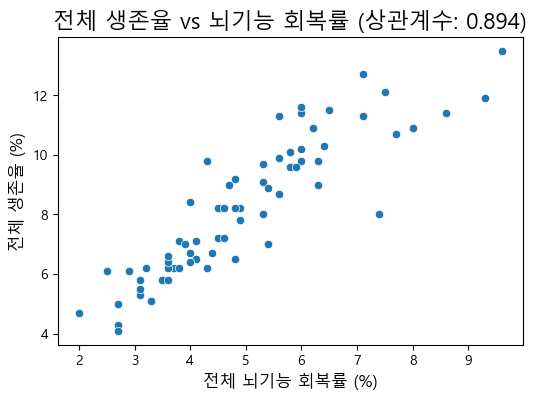

In [60]:
plt.figure(figsize=(6, 4))

sns.scatterplot(data=final_heart_df, x='전체 뇌기능 회복률', y='전체 생존율')
plt.title(f'전체 생존율 vs 뇌기능 회복률 (상관계수: {correlation1:.3f})', fontsize=16)
plt.xlabel('전체 뇌기능 회복률 (%)', fontsize=12)
plt.ylabel('전체 생존율 (%)', fontsize=12)
plt.show()

In [61]:
# 급성심정지 생존율과 발생률의 상관관계 확인
correlation2 = final_heart_df[['전체 생존율', '전체 발생률']].corr().iloc[0, 1]
print(f"급성심장정지 생존율과 발생률의 상관계수: {correlation2:.3f}")

급성심장정지 생존율과 발생률의 상관계수: -0.795


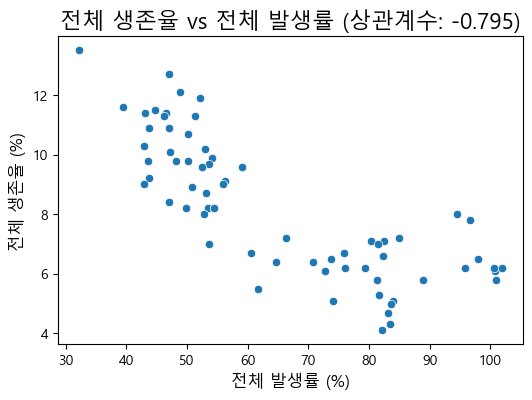

In [62]:
plt.figure(figsize=(6, 4))

sns.scatterplot(data=final_heart_df, x='전체 발생률', y='전체 생존율')
plt.title(f'전체 생존율 vs 전체 발생률 (상관계수: {correlation2:.3f})', fontsize=16)
plt.xlabel('전체 발생률 (%)', fontsize=12)
plt.ylabel('전체 생존율 (%)', fontsize=12)
plt.show()

In [63]:
# 병원 개수와 생존율의 상관관계 확인
correlation3 = final_heart_df[['병원 합계', '전체 생존율']].corr().iloc[0, 1]
print(f"병원합계와 생존율의 상관계수: {correlation3:.3f}")

병원합계와 생존율의 상관계수: 0.222


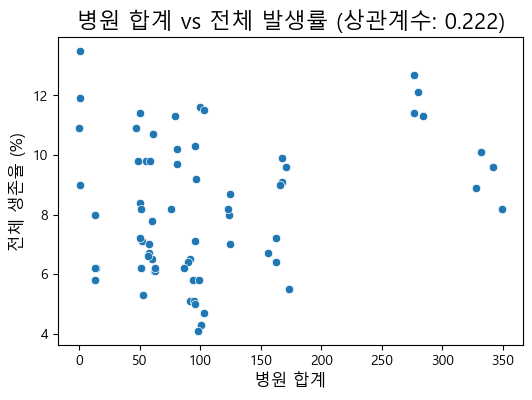

In [64]:
plt.figure(figsize=(6, 4))

sns.scatterplot(data=final_heart_df, x='병원 합계', y='전체 생존율')
plt.title(f'병원 합계 vs 전체 발생률 (상관계수: {correlation3:.3f})', fontsize=16)
plt.xlabel('병원 합계', fontsize=12)
plt.ylabel('전체 생존율 (%)', fontsize=12)
plt.show()

In [65]:
# 병원 개수와 뇌기능 회복률의 상관관계 확인
correlation4 = final_heart_df[['병원 합계', '전체 뇌기능 회복률']].corr().iloc[0, 1]
print(f"병원합계와 뇌기능 회복률의 상관계수: {correlation4:.3f}")

병원합계와 뇌기능 회복률의 상관계수: 0.083


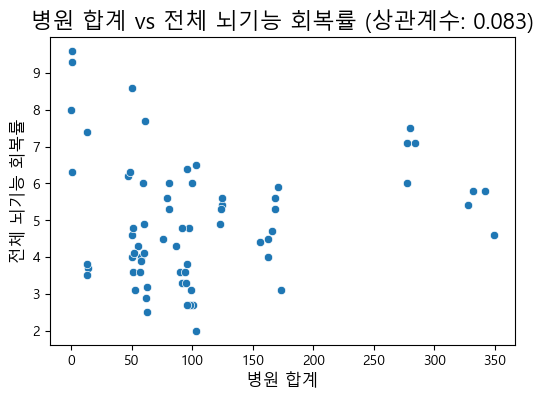

In [66]:
plt.figure(figsize=(6, 4))

sns.scatterplot(data=final_heart_df, x='병원 합계', y='전체 뇌기능 회복률')
plt.title(f'병원 합계 vs 전체 뇌기능 회복률 (상관계수: {correlation4:.3f})', fontsize=16)
plt.xlabel('병원 합계', fontsize=12)
plt.ylabel('전체 뇌기능 회복률', fontsize=12)
plt.show()

#### 탐색적 데이터 분석 + 시각화

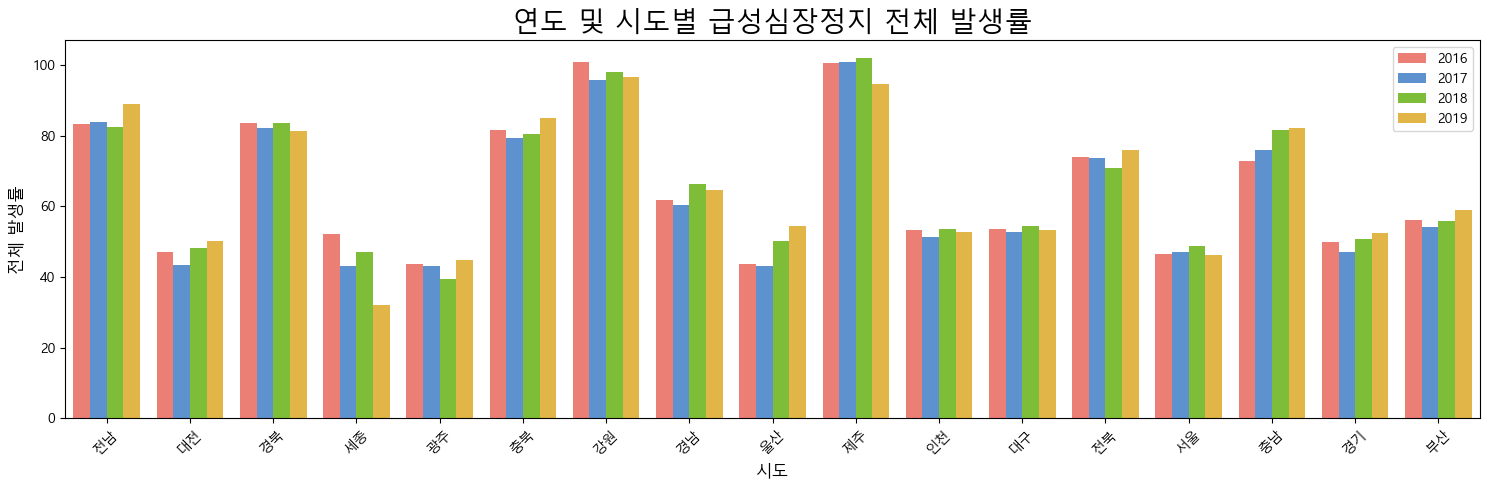

In [67]:
heart_occur_melted = heart_occur.melt(id_vars=['연도', '시도'], 
                                      value_vars=['전체 발생률'],
                                      var_name='변수', value_name='값')

plt.figure(figsize=(15, 5))
sns.barplot(data=heart_occur_melted, x='시도', y='값', hue='연도', palette=['#FF6F61', '#4A90E2', '#7ED321', '#FBC02D'])

plt.title('연도 및 시도별 급성심장정지 전체 발생률', fontsize=20)
plt.xlabel('시도', fontsize=12)
plt.ylabel('전체 발생률', fontsize=12)
plt.xticks(rotation=45)  

plt.legend()
plt.tight_layout()
plt.show()

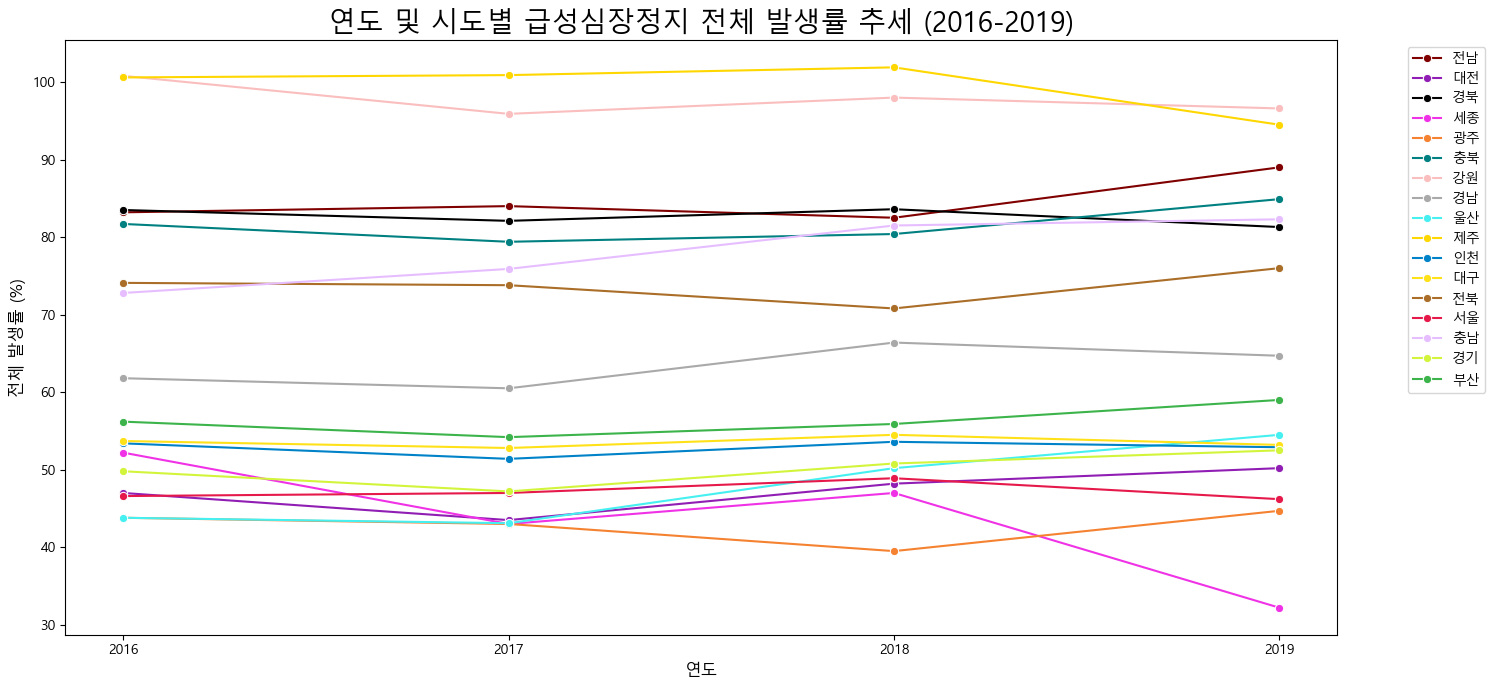

In [68]:
plt.figure(figsize=(15, 7))

palette = {
    '서울': '#E6194B', '부산': '#3CB44B', '대구': '#FFE119', '인천': '#0082C8', '광주': '#F58231',
    '대전': '#911EB4', '울산': '#46F0F0', '세종': '#F032E6', '경기': '#D2F53C', '강원': '#FABEBE',
    '충북': '#008080', '충남': '#E6BEFF', '전북': '#AA6E28', '전남': '#800000', '경북': '#000000',
    '경남': '#A9A9A9', '제주': '#FFD700'
}

sns.lineplot(data=heart_occur_melted, x='연도', y='값', hue='시도', marker='o', palette= palette)

plt.title('연도 및 시도별 급성심장정지 전체 발생률 추세 (2016-2019)', fontsize=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('전체 발생률 (%)', fontsize=12)
plt.xticks([2016, 2017, 2018, 2019])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


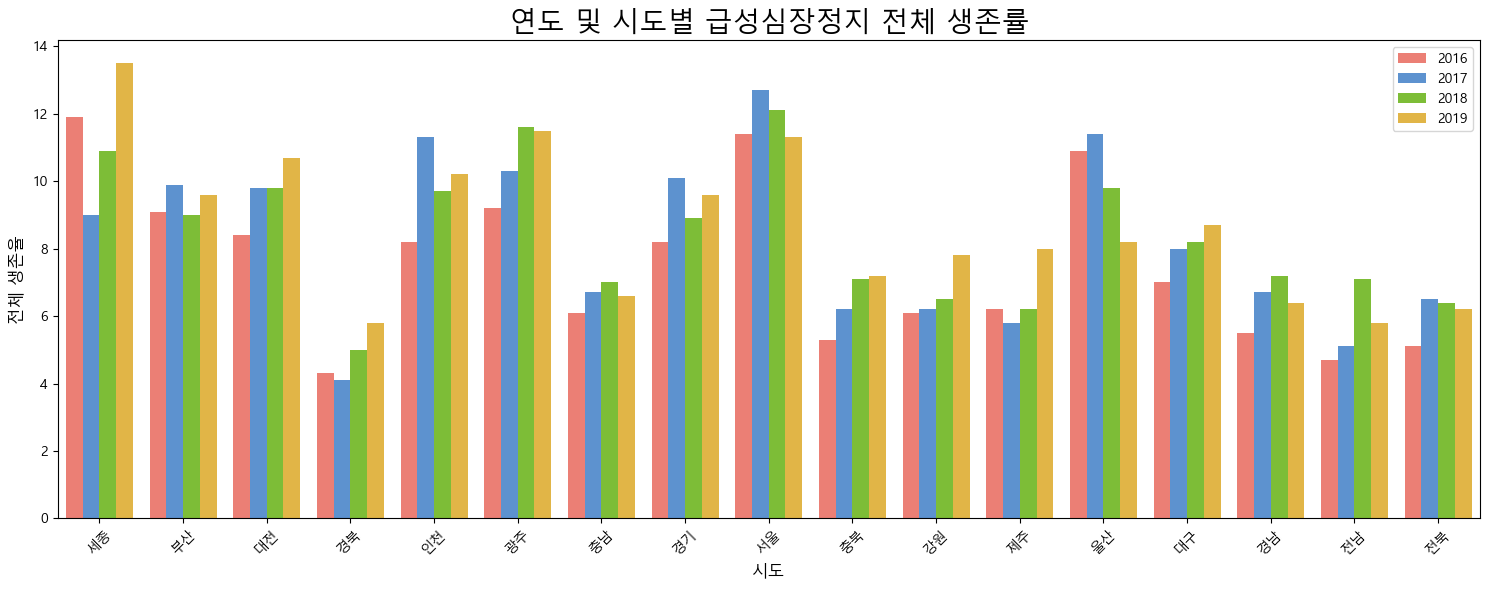

In [69]:
heart_live_melted = heart_live.melt(id_vars=['연도', '시도'], 
                                      value_vars=['전체 생존율'],
                                      var_name='변수', value_name='값')

plt.figure(figsize=(15, 6))
sns.barplot(data=heart_live_melted, x='시도', y='값', hue='연도', palette=['#FF6F61', '#4A90E2', '#7ED321', '#FBC02D'])

plt.title('연도 및 시도별 급성심장정지 전체 생존률', fontsize=20)
plt.xlabel('시도', fontsize=12)
plt.ylabel('전체 생존율', fontsize=12)
plt.xticks(rotation=45)  

plt.legend()
plt.tight_layout()
plt.show()

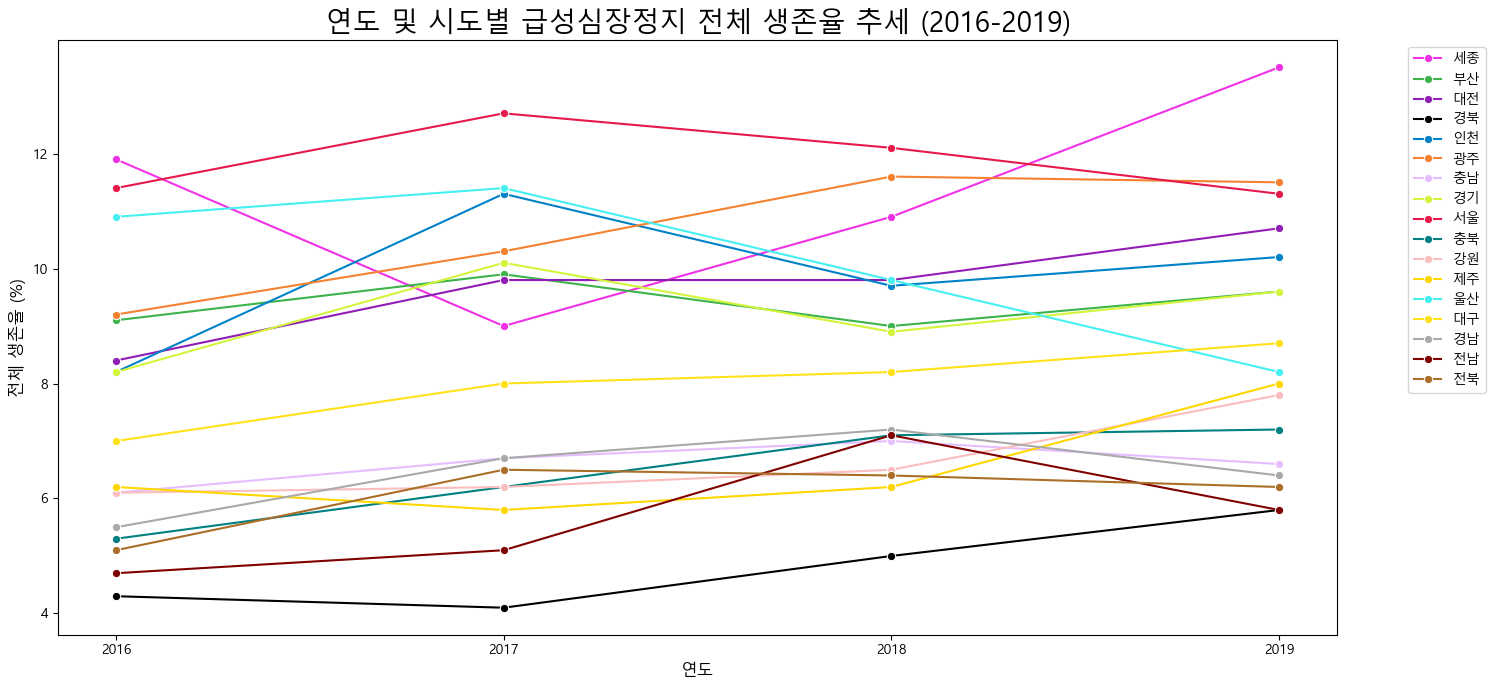

In [70]:
plt.figure(figsize=(15, 7))

sns.lineplot(data=heart_live_melted, x='연도', y='값', hue='시도', marker='o', palette= palette)

plt.title('연도 및 시도별 급성심장정지 전체 생존율 추세 (2016-2019)', fontsize=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('전체 생존율 (%)', fontsize=12)
plt.xticks([2016, 2017, 2018, 2019])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


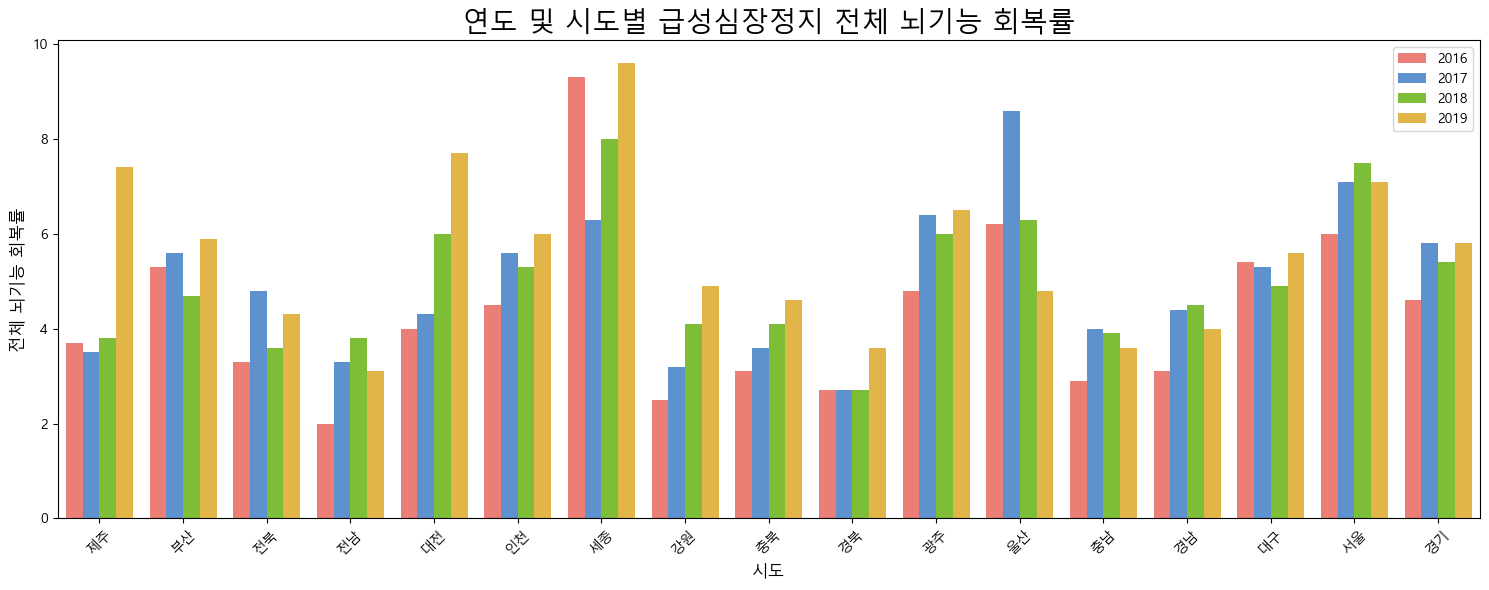

In [71]:
heart_heal_melted = heart_heal.melt(id_vars=['연도', '시도'], 
                                      value_vars=['전체 뇌기능 회복률'],
                                      var_name='변수', value_name='값')

plt.figure(figsize=(15, 6))
sns.barplot(data=heart_heal_melted, x='시도', y='값', hue='연도', palette=['#FF6F61', '#4A90E2', '#7ED321', '#FBC02D'])

plt.title('연도 및 시도별 급성심장정지 전체 뇌기능 회복률', fontsize=20)
plt.xlabel('시도', fontsize=12)
plt.ylabel('전체 뇌기능 회복률', fontsize=12)
plt.xticks(rotation=45)  

plt.legend()
plt.tight_layout()
plt.show()

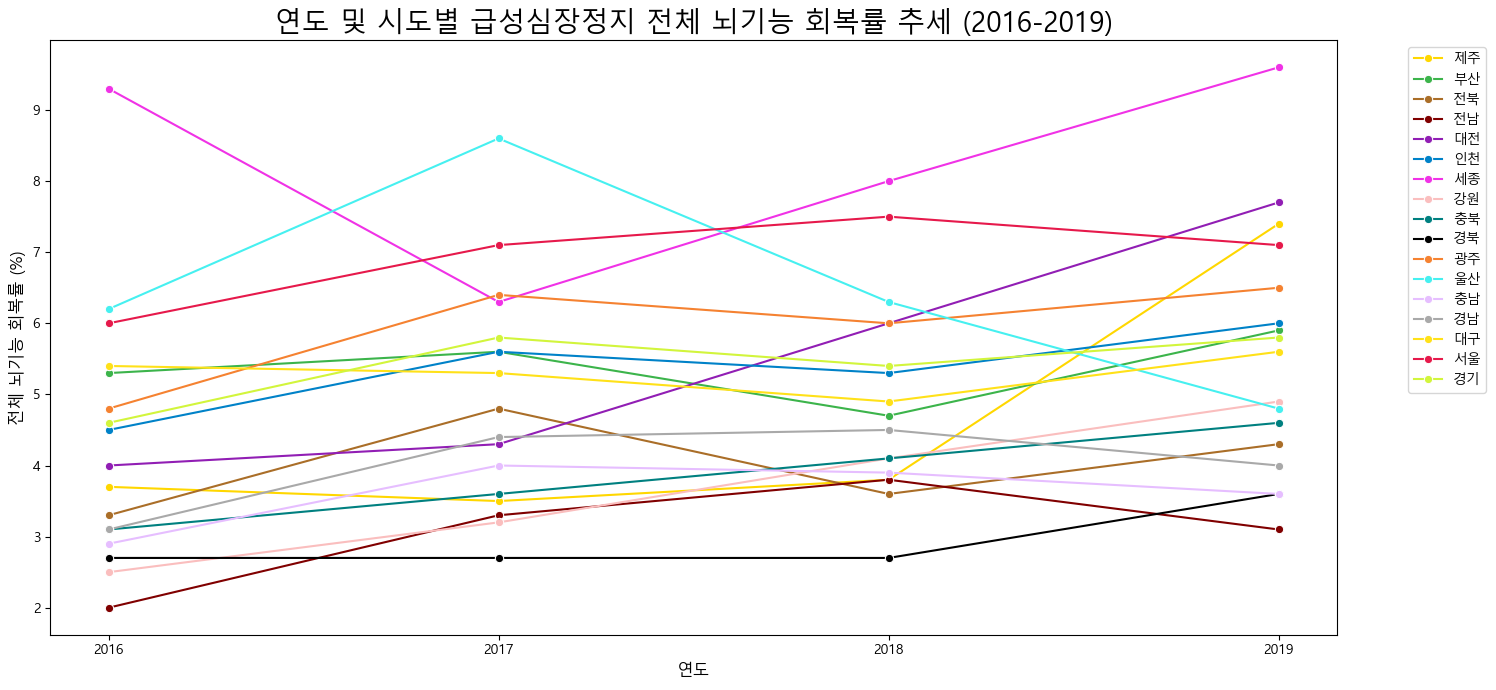

In [72]:
plt.figure(figsize=(15, 7))

sns.lineplot(data=heart_heal_melted, x='연도', y='값', hue='시도', marker='o', palette= palette)

plt.title('연도 및 시도별 급성심장정지 전체 뇌기능 회복률 추세 (2016-2019)', fontsize=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('전체 뇌기능 회복률 (%)', fontsize=12)
plt.xticks([2016, 2017, 2018, 2019])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

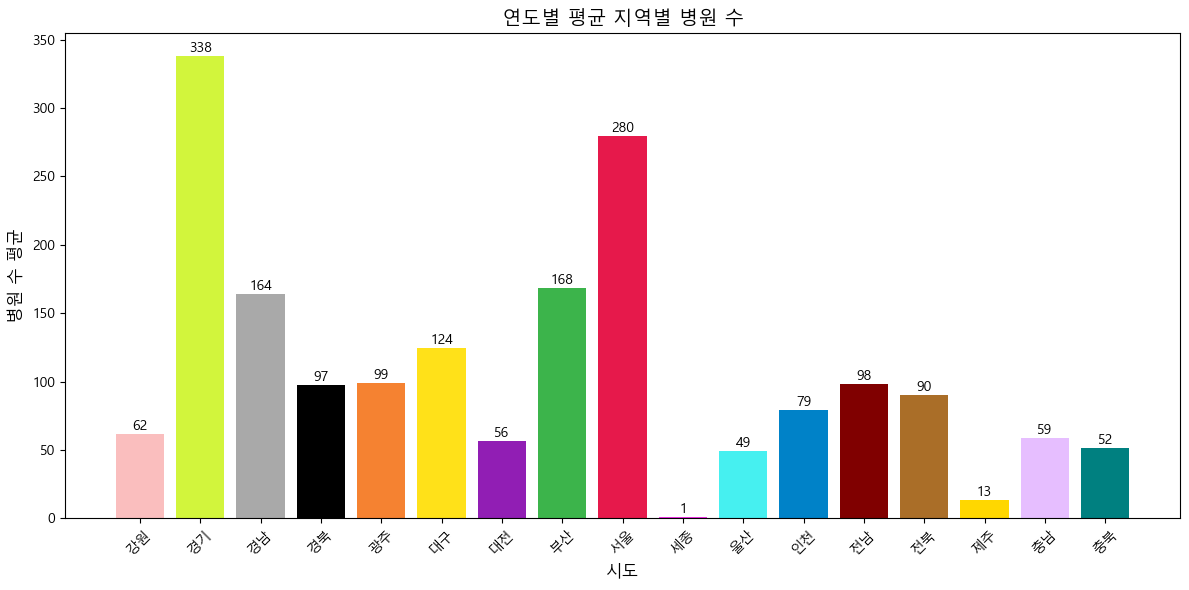

In [73]:
mean_df = final_heart_df.groupby('시도')['병원 합계'].mean().reset_index()

colors = [palette[sido] for sido in mean_df['시도']]

# 시도별 병원 평균 막대그래프
plt.figure(figsize=(12, 6))
bars = plt.bar(mean_df['시도'], mean_df['병원 합계'], color=colors)

plt.title('연도별 평균 지역별 병원 수', fontsize=14)
plt.xlabel('시도', fontsize=12)
plt.ylabel('병원 수 평균', fontsize=12)

# 값 라벨 위에 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.0f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 머신러닝 모델 생성 및 비교

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

In [75]:
# RandomForest Model
x = final_heart_df[['전체 발생률', '전체 뇌기능 회복률', '병원 합계']]
y = final_heart_df['전체 생존율']

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 모델 학습
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(x_train, y_train)

# 예측 및 평가
y_pred = rf_model.predict(x_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.3f}")
print(f'Mean Squared Error: {mse:.3f}')

R²: 0.952
Mean Squared Error: 0.231


In [76]:
# RandomForest 모델 교차검증
scores = cross_val_score(rf_model, x, y, cv=5, scoring='r2')
print(scores)
print(f'R² 평균: {scores.mean():.3f}, 표준편차: {scores.std():.3f}')

[0.84405306 0.82590827 0.86147703 0.89821117 0.81843499]
R² 평균: 0.850, 표준편차: 0.029


In [77]:
# Gradient Boosting Model

# 모델 학습
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(x_train, y_train)


# 예측 및 평가
gb_pred = gb_model.predict(x_test)
gb_mse = mean_squared_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)


print(f"R²: {gb_r2:.3f}")
print(f"Mean Squared Error: {gb_mse:.3f}")

R²: 0.925
Mean Squared Error: 0.359


In [78]:
# Gradient Boosting 모델 교차검증
scores2 = cross_val_score(gb_model, x, y, cv=5, scoring='r2')
print(scores2)
print(f'R² 평균: {scores2.mean():.3f}, 표준편차: {scores2.std():.3f}')

[0.86436088 0.80083593 0.83736625 0.92731919 0.77267487]
R² 평균: 0.841, 표준편차: 0.053


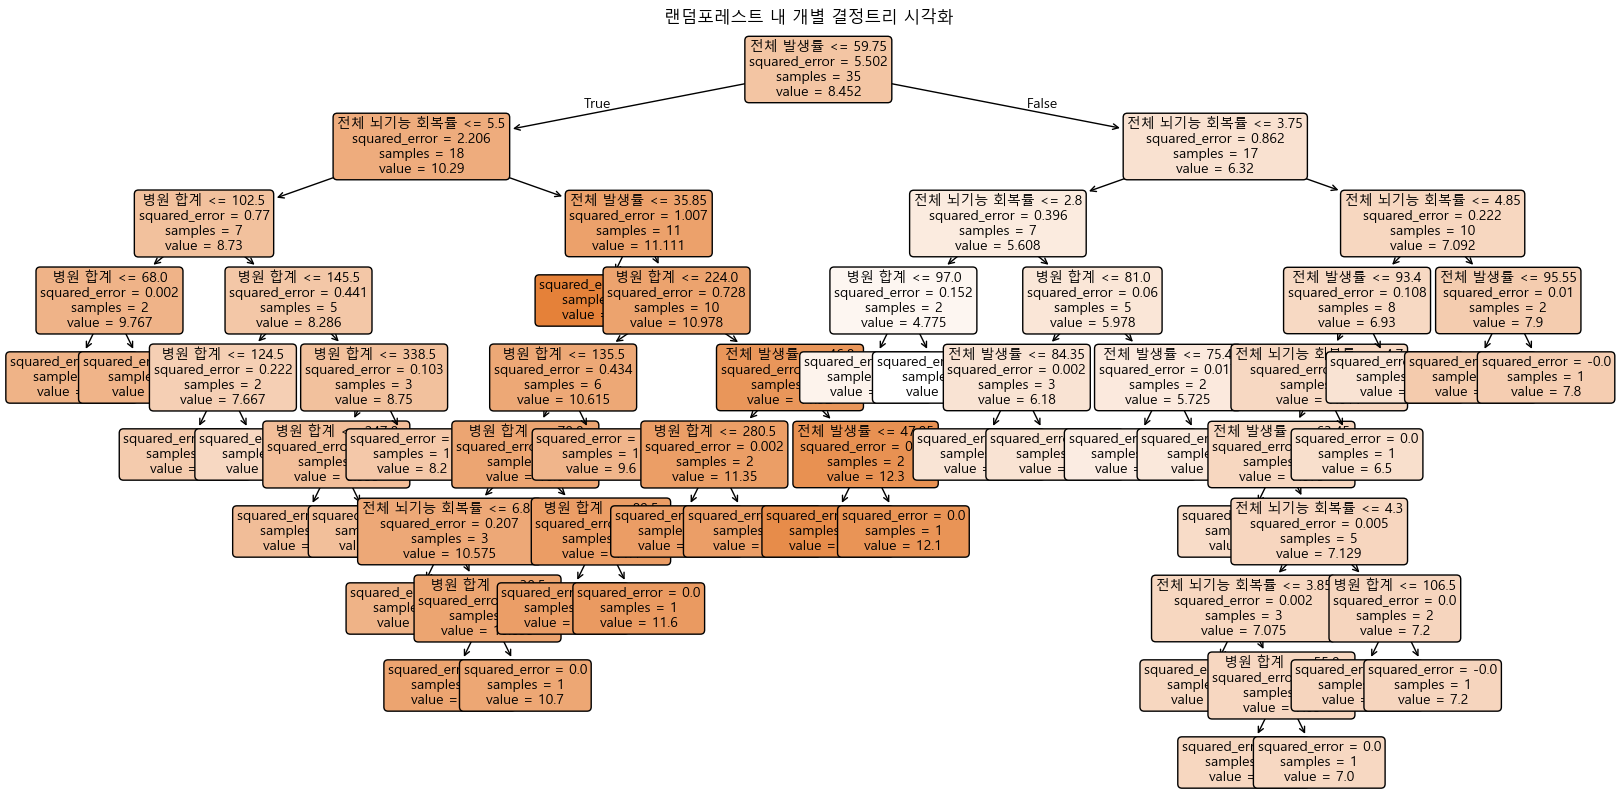

In [ ]:
# 랜덤포레스트에서 첫 번째 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], 
          feature_names=['전체 발생률', '전체 뇌기능 회복률', '병원 합계'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("랜덤포레스트 내 개별 결정트리 시각화")
plt.show()


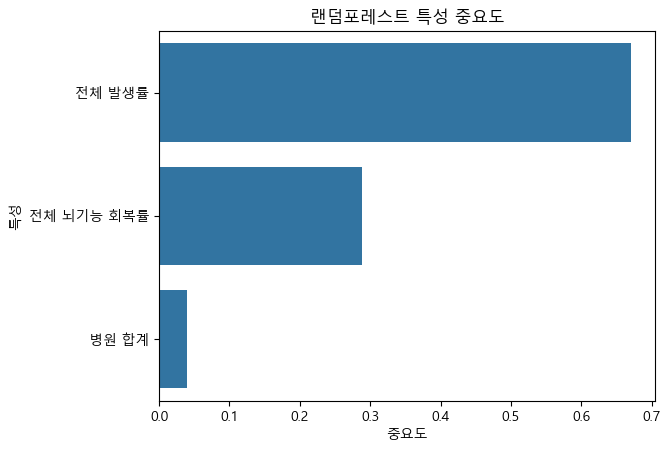

In [ ]:
# 특성 중요도 추출
importances = rf_model.feature_importances_
features = ['전체 발생률', '전체 뇌기능 회복률', '병원 합계']

sns.barplot(x=importances, y=features)
plt.title("랜덤포레스트 특성 중요도")
plt.xlabel("중요도")
plt.ylabel("특성")
plt.show()


In [81]:
sample_row = final_heart_df[final_heart_df['시도'] == '서울']
predicted_data = sample_row[['연도', '시도', '전체 생존율', '전체 발생률', '전체 뇌기능 회복률', '병원 합계']]
predicted_data

,연도,시도,전체 생존율,전체 발생률,전체 뇌기능 회복률,병원 합계
8,2016,서울,11.4,46.6,6.0,277
32,2017,서울,12.7,47.0,7.1,277
43,2018,서울,12.1,48.9,7.5,280
67,2019,서울,11.3,46.2,7.1,284


In [82]:
predict_df = pd.DataFrame({
    '전체 발생률': [47.3],
    '전체 뇌기능 회복률': [7.2],
    '병원 합계': [286]
})

# Random Forest Model 예측
predicted_survival = rf_model.predict(predict_df)
print(f"예측된 전체 생존율 (Random Forest Model): {predicted_survival[0]:.2f}")

# Gradient Boosting Model 예측
predicted_survival = gb_model.predict(predict_df)
print(f"예측된 전체 생존율 (Gradient Boosting Model): {predicted_survival[0]:.2f}")

예측된 전체 생존율 (Random Forest Model): 11.90
예측된 전체 생존율 (Gradient Boosting Model): 11.57


In [83]:
def predict_survival_rate(occur_rate, brain_heal_rate, hospital_count):
    predict_df = pd.DataFrame({
        '전체 발생률': [occur_rate],
        '전체 뇌기능 회복률': [brain_heal_rate],
        '병원 합계': [hospital_count] })
    
    pred_rf = rf_model.predict(predict_df)[0]
    pred_gb = gb_model.predict(predict_df)[0]
    
    print(f"입력 받은 전체 발생률: {occur_rate}")
    print(f"입력 받은 전체 뇌기능 회복률: {brain_heal_rate}")
    print(f"입력 받은 병원 합계: {hospital_count}")
    print("--------------------------")
    print(f"Random Forest 예측 생존율: {pred_rf:.2f}%")
    print(f"Gradient Boosting 예측 생존율: {pred_gb:.2f}%")

In [84]:
predict_survival_rate(47.3, 7.2, 286)

입력 받은 전체 발생률: 47.3
입력 받은 전체 뇌기능 회복률: 7.2
입력 받은 병원 합계: 286
--------------------------
Random Forest 예측 생존율: 11.90%
Gradient Boosting 예측 생존율: 11.57%


In [85]:
predict_survival_rate(53.6, 5.2, 121)

입력 받은 전체 발생률: 53.6
입력 받은 전체 뇌기능 회복률: 5.2
입력 받은 병원 합계: 121
--------------------------
Random Forest 예측 생존율: 8.35%
Gradient Boosting 예측 생존율: 8.23%
